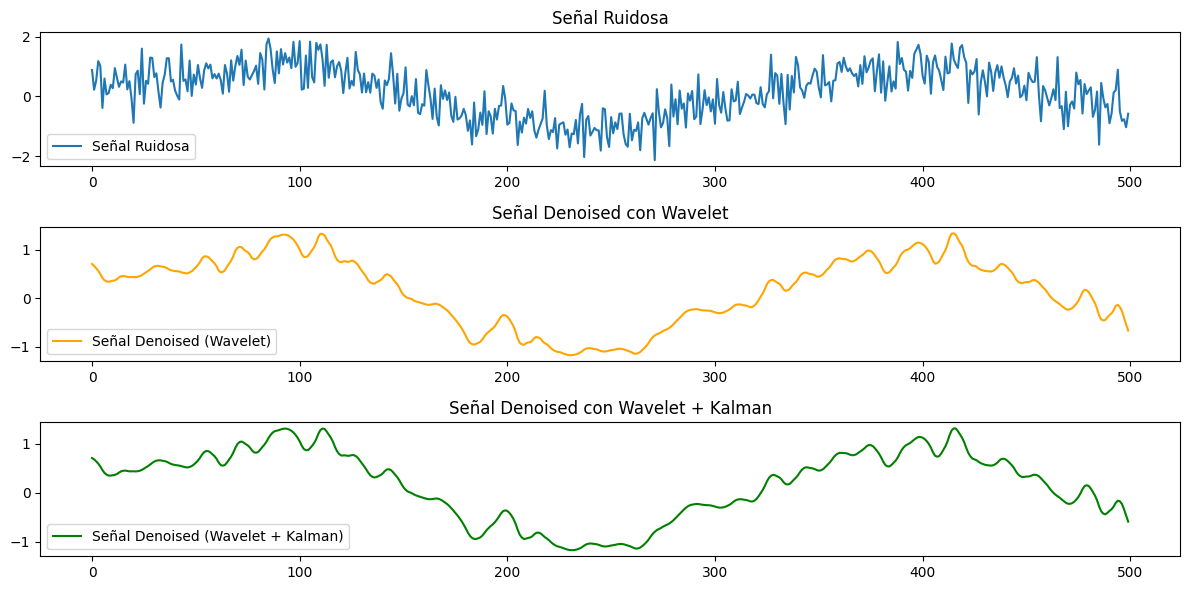

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from filterpy.kalman import KalmanFilter

# Generar una señal de tipo Nanopore (pulsos)
def generate_nanopore_signal(length=500, pulse_height=0.5, pulse_width=10, noise_std=0.1):
    # Crear una señal base de ceros
    signal = np.zeros(length)
    
    # Agregar pulsos aleatorios a la señal
    num_pulses = int(length / 20)  # Aproximadamente un pulso cada 20 puntos
    for _ in range(num_pulses):
        pulse_start = np.random.randint(0, length - pulse_width)
        pulse_end = pulse_start + pulse_width
        signal[pulse_start:pulse_end] = pulse_height
    
    # Añadir ruido gaussiano para simular el ruido de la señal
    noise = np.random.normal(0, noise_std, size=length)
    signal += noise
    
    return signal

# Función de Transformada Wavelet Discreta (DWT) para reducción de ruido
def wavelet_denoise(signal, wavelet='db4', level=3):
    # Descomponer la señal usando DWT
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Eliminar ruido en los coeficientes de detalle (usando umbral)
    threshold = np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, threshold, mode='soft') for i in coeffs[1:]]
    
    # Reconstruir la señal con los coeficientes modificados
    denoised_signal = pywt.waverec(coeffs, wavelet)
    
    return denoised_signal

# Función para aplicar un filtro de Kalman
def kalman_filter(signal):
    # Inicialización del filtro de Kalman
    kf = KalmanFilter(dim_x=1, dim_z=1)
    
    # Inicializamos el estado y la covarianza
    kf.x = np.array([signal[0]])  # Estado inicial
    kf.P *= 1000.0  # Alta incertidumbre inicial
    kf.F = np.array([[1]])  # Transición del estado (modelo lineal)
    kf.H = np.array([[1]])  # Medición directa
    kf.R = 0.1  # Ruido de medición (ajustable)
    kf.Q = 0.1  # Ruido del proceso (ajustable)
    
    denoised_signal = []
    
    for z in signal:
        kf.predict()
        kf.update(z)
        denoised_signal.append(kf.x[0])
    
    return np.array(denoised_signal)

# Simular la señal de Nanopore (con pulsos)
np.random.seed(0)
original_signal = generate_nanopore_signal(length=500)

# Aplicar la reducción de ruido usando Wavelet
wavelet_denoised_signal = wavelet_denoise(original_signal)

# Aplicar el filtro de Kalman sobre la señal denoised por Wavelet
kalman_denoised_signal = kalman_filter(wavelet_denoised_signal)

# Mostrar resultados
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(original_signal, label='Señal Ruidosa (Pulsos)', color='red')
plt.title("Señal de Nanopore (Ruidosa)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(wavelet_denoised_signal, label='Señal Denoised (Wavelet)', color='orange')
plt.title("Señal Denoised con Wavelet")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(kalman_denoised_signal, label='Señal Denoised (Wavelet + Kalman)', color='green')
plt.title("Señal Denoised con Wavelet + Kalman")
plt.legend()

plt.tight_layout()
plt.show()
